# Linguistics Project
*Sentiment Analysis*

*Farhan K, Haroon S, Galaan O,  Nafi K, Isaac N*

# *Installing All Python Libraries/Modules*
*Using pip*


In [ ]:
!pip install transformers pandas datasets nltk beautifulsoup4 torch evaluate transformers[torch] scikit-learn matplotlib seaborn

# *Importing NLTK + Downloading Stopwords and Punkt*

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')


# *Importing Necessary Modules*

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline

from datasets import load_dataset
from bs4 import BeautifulSoup
import re

import numpy as np
import evaluate

# *Loading Dataset from Huggingface*

In [ ]:
# Load dataset and specify the data directory
dataset = load_dataset('stanfordnlp/imdb')

# *Removing HTML Elements w/Beautiful Soup*

In [ ]:
def remove_html_tags(example):
    # Extract the 'text' field from the example
    text = example['text']

    # Parse HTML content and remove tags
    soup = BeautifulSoup(text, 'html.parser')
    text_without_html = soup.get_text(separator=' ')
    text_without_html = re.sub(r'\s+', ' ', text_without_html).strip()

    # Update the 'text' field in the example with processed text
    example['text'] = text_without_html

    return example

# *Cleaning The Reviews w/NLTK*

*Meant For batches of data!*

In [2]:
def clean_review(review):
    # Tokenize the text into words
    tokens = word_tokenize(review['text'])

    # Define stopwords, punctuation characters, and contractions
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    contractions = {
        "n't": "not",
        "'s": "",
        "'re": "are",
        "'ve": "have",
        "'d": "would",
        "'ll": "will",
        "'m": "am"
    }

    # Function to handle contractions and remove punctuation
    def process_token(token):
        token_lower = token.lower()
        if token_lower in contractions:
            cleaned_token = contractions[token_lower]
            return cleaned_token if cleaned_token != "" else None
        elif token_lower not in stop_words and token_lower not in punctuation:
            return token

    # Filter out stopwords, punctuation, and handle contractions
    filtered_tokens = [process_token(token) for token in tokens]
    filtered_tokens = [token for token in filtered_tokens if token is not None]

    # Reconstruct the text from filtered tokens
    cleaned_text = ' '.join(filtered_tokens)

    # Update the 'text' field in the Review with cleaned text
    review['text'] = cleaned_text

    return review

## *Cleaning a Single Text/Review (not meant for batches)*

In [ ]:
def clean_review_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Define stopwords, punctuation characters, and contractions
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    contractions = {
        "n't": "not",
        "'s": "",
        "'re": "are",
        "'ve": "have",
        "'d": "would",
        "'ll": "will",
        "'m": "am"
    }

    # Filter out stopwords, punctuation, and handle contractions
    filtered_tokens = []
    for token in tokens:
        token_lower = token.lower()
        if token_lower in contractions:
            cleaned_token = contractions[token_lower]
            if cleaned_token != "":
                filtered_tokens.append(cleaned_token)
        elif token_lower not in stop_words and token_lower not in punctuation:
            filtered_tokens.append(token)

    # Reconstruct the text from filtered tokens
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text

## *Setting Labels*

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# *Loading In Huggingface Model and Tokenizer*

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, id2label=id2label, label2id=label2id,
    ignore_mismatched_sizes=True
)

## *Creating a Model_Tokenizer Function*

In [3]:
def model_tokenizer(reviews):
     return tokenizer(reviews["text"], padding="max_length", max_length=512, truncation=True)

## *The Different Data Splits we Want To Process*

In [ ]:
splits_to_process = ['train', 'test', 'unsupervised']

## *Preprocessing Data: HTML Tags*

In [ ]:
# Batch size for processing
batch_size=1000

new_dataset = dataset

for split in splits_to_process:
    # Apply the remove_html_tags function to the 'text' column in the specified split
    new_dataset[split] = new_dataset[split].map(remove_html_tags)
    new_dataset[split] = new_dataset[split].map(clean_review)


## *Tokenizing The Dataset(s)*

In [ ]:
tokenized_datasets = new_dataset.map(model_tokenizer, batched=True, batch_size=batch_size)

## *Setting The Data Collator*

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## *Setting Small Datasets for Testing*
### *Used For Testing Small Amounts of Data*

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

# *Computing Metrics*
## *Used During Training Process*

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# *Hardware Checks: CPU or GPU*
## *For Nvidea Architecture*

In [ ]:
import torch
from transformers import TrainingArguments, Trainer

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")

model.to(device)

#*Training The Model*
## *Training Args Included*

In [ ]:
training_args = TrainingArguments(
    output_dir="model_3e-5",
    learning_rate=3e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# *Model Evaluation*
## *Metric Data*

In [ ]:
# Evaluate the trained model
eval_results = trainer.evaluate()

# Print evaluation results including accuracy, precision, recall, and F1 score
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

# *Graphing Data*
## *Saved As PNG*

In [ ]:
train_logs = trainer.state.log_history

### *Training Loss + Evaluation Metrics Plots*

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Extract relevant data
epochs = [log['epoch'] for log in train_logs if 'epoch' in log]
train_loss = [log['loss'] for log in train_logs if 'loss' in log]

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.legend()

# Save the plot as PNG
plt.savefig('training_loss_plot.png')
plt.close()  # Close the current figure to free memory

# Extract evaluation metrics data
eval_epochs = [log['epoch'] for log in train_logs if 'eval_accuracy' in log]
eval_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]
eval_precision = [log['eval_precision'] for log in train_logs if 'eval_precision' in log]
eval_recall = [log['eval_recall'] for log in train_logs if 'eval_recall' in log]
eval_f1 = [log['eval_f1'] for log in train_logs if 'eval_f1' in log]

# Plotting evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label='Accuracy', marker='o')
plt.plot(eval_epochs[:len(eval_precision)], eval_precision, label='Precision', marker='o')
plt.plot(eval_epochs[:len(eval_recall)], eval_recall, label='Recall', marker='o')
plt.plot(eval_epochs[:len(eval_f1)], eval_f1, label='F1 Score', marker='o')
plt.title('Evaluation Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()

# Save the plot as PNG
plt.savefig('evaluation_metrics_plot.png')
plt.close()  # Close the current figure to free memory

### *Validation Accuracy And Loss Plots*

In [ ]:
# Extract additional metrics from logs
# Example: validation accuracy and loss
val_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]
val_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]

# Plotting additional metrics
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs[:len(val_accuracy)], val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(eval_epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')
plt.title('Validation Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()

# Save the plot as PNG
plt.savefig('validation_metrics_plot.png')
plt.close()


# *Using The Model!*


### *Loading Model and Tokenizer*

In [ ]:
model_path = "checkpoint-15625"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Note: Model Files Are Too Large For Uploading To Canvas

### *Setting the Classifier/Pipeline*

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

### *Evaluating Text*

In [ ]:
text = "LING5801 is a fire class (no cap), I will def tell my friends to take this class!!!!!!"

In [ ]:
result = classifier(text)

In [ ]:
result

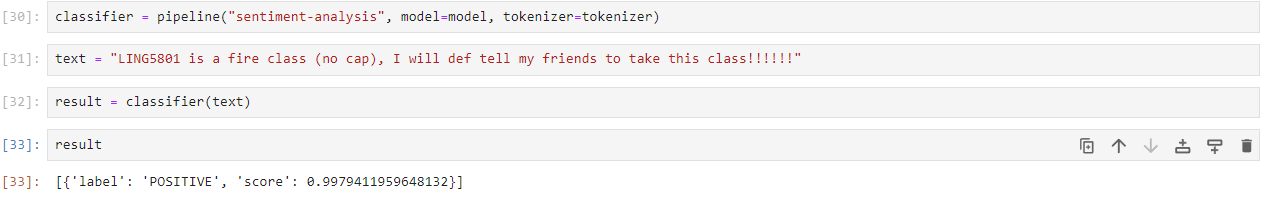